In [29]:
# modelagem e dados
import torch
from torch import nn, optim

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt

# operações de imagem
import cv2

# outros
import os
import numpy as np
from tqdm import tqdm

In [30]:
from model.model_up_bilinear import SegNet
from dataset.dataloader_aerial import train_loader, val_loader, test_loader


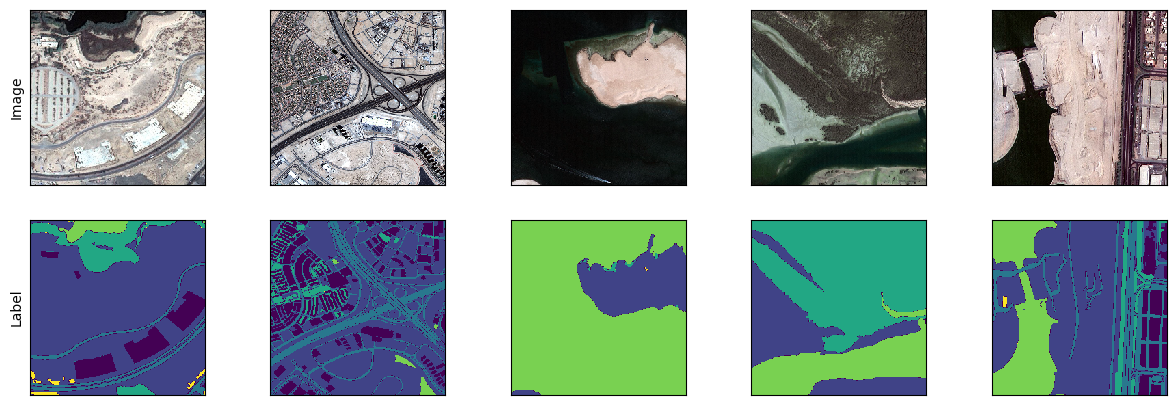

In [31]:
w = 5
fig, ax = plt.subplots(2, w, figsize=(15, 5))

ax[0][0].set_ylabel("Image")
ax[1][0].set_ylabel("Label")

for j in range(w):
    instances, targets = next(iter(train_loader))
    ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [33]:
model = SegNet(output_size=6).to(device)
# model.load_state_dict(torch.load(r"model\weights\best.zip"))
summary(SegNet().to(device), (3, 224, 224), 1, device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
       BatchNorm2d-3          [1, 64, 224, 224]             128
            Conv2d-4          [1, 64, 224, 224]          36,928
              ReLU-5          [1, 64, 224, 224]               0
       BatchNorm2d-6          [1, 64, 224, 224]             128
         MaxPool2d-7          [1, 64, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]          73,856
              ReLU-9         [1, 128, 112, 112]               0
      BatchNorm2d-10         [1, 128, 112, 112]             256
           Conv2d-11         [1, 128, 112, 112]         147,584
             ReLU-12         [1, 128, 112, 112]               0
      BatchNorm2d-13         [1, 128, 112, 112]             256
        MaxPool2d-14           [1, 128,

In [34]:
train_losses = list()
valid_losses = list()

In [35]:
EPOCHS = 500
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [36]:
def train_step(model, loader, loss_fn, optimizer, device) -> float:
  train_loss = 0
  for X, Y in loader:
    y_pred = model(X.to(device))
    loss = loss_fn(y_pred, Y.to(device))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  return train_loss / len(loader)


def validation_step(model, loader, loss_fn, device) -> float:
  loss = 0
  with torch.no_grad():
    for X, Y in loader:
      y_pred = model(X.to(device))
      loss += loss_fn(y_pred, Y.to(device)).item()
  return loss / len(loader)

In [37]:
from tqdm import tqdm
from copy import deepcopy

def train_model():
  for epoch in tqdm(range(EPOCHS)):
    train_losses.append(train_step(model, train_loader, loss_fn, optimizer, device))
    valid_losses.append(validation_step(model, val_loader, loss_fn, device))
    if valid_losses[-1] == min(valid_losses):
      best_model = deepcopy(model)
    print("\fLoss: {}\n".format(valid_losses[-1]))
  return best_model

In [38]:
best_model = train_model()

  0%|          | 1/500 [00:03<29:50,  3.59s/it]

Loss: 1.3470737934112549



  0%|          | 2/500 [00:07<29:09,  3.51s/it]

Loss: 1.3148199319839478



  1%|          | 3/500 [00:10<28:33,  3.45s/it]

Loss: 1.3082818984985352



  1%|          | 4/500 [00:13<28:14,  3.42s/it]

Loss: 1.307291030883789



  1%|          | 5/500 [00:17<28:15,  3.43s/it]

Loss: 1.305109977722168



  1%|          | 6/500 [00:20<27:47,  3.38s/it]

Loss: 1.3014788627624512



  1%|▏         | 7/500 [00:23<27:32,  3.35s/it]

Loss: 1.289324164390564



  2%|▏         | 8/500 [00:27<27:26,  3.35s/it]

Loss: 1.2866153717041016



  2%|▏         | 9/500 [00:30<27:15,  3.33s/it]

Loss: 1.285949945449829



  2%|▏         | 10/500 [00:33<27:14,  3.34s/it]

Loss: 1.2835148572921753



  2%|▏         | 11/500 [00:37<27:18,  3.35s/it]

Loss: 1.2868554592132568



  2%|▏         | 12/500 [00:40<27:32,  3.39s/it]

Loss: 1.3024334907531738



  3%|▎         | 13/500 [00:44<27:35,  3.40s/it]

Loss: 1.2922451496124268



  3%|▎         | 14/500 [00:47<27:39,  3.41s/it]

Loss: 1.2827558517456055



  3%|▎         | 15/500 [00:50<27:38,  3.42s/it]

Loss: 1.2681670188903809



  3%|▎         | 16/500 [00:54<27:36,  3.42s/it]

Loss: 1.2614635229110718



  3%|▎         | 17/500 [00:57<27:36,  3.43s/it]

Loss: 1.2607395648956299



  4%|▎         | 18/500 [01:01<27:35,  3.44s/it]

Loss: 1.2734835147857666



  4%|▍         | 19/500 [01:04<27:37,  3.45s/it]

Loss: 1.2663652896881104



  4%|▍         | 20/500 [01:08<27:37,  3.45s/it]

Loss: 1.2530750036239624



  4%|▍         | 21/500 [01:11<27:36,  3.46s/it]

Loss: 1.250101089477539



  4%|▍         | 22/500 [01:15<27:35,  3.46s/it]

Loss: 1.255968689918518



  5%|▍         | 23/500 [01:18<27:32,  3.47s/it]

Loss: 1.2433433532714844



  5%|▍         | 24/500 [01:22<27:30,  3.47s/it]

Loss: 1.2454441785812378



  5%|▌         | 25/500 [01:25<27:27,  3.47s/it]

Loss: 1.29006826877594



  5%|▌         | 26/500 [01:29<27:24,  3.47s/it]

Loss: 1.2582732439041138



  5%|▌         | 27/500 [01:32<27:20,  3.47s/it]

Loss: 1.2393947839736938



  6%|▌         | 28/500 [01:35<27:13,  3.46s/it]

Loss: 1.2483869791030884



  6%|▌         | 29/500 [01:39<27:07,  3.46s/it]

Loss: 1.2784541845321655



  6%|▌         | 30/500 [01:42<27:02,  3.45s/it]

Loss: 1.2639738321304321



  6%|▌         | 31/500 [01:46<27:02,  3.46s/it]

Loss: 1.2386044263839722



  6%|▋         | 32/500 [01:49<27:00,  3.46s/it]

Loss: 1.2413866519927979



  7%|▋         | 33/500 [01:53<26:57,  3.46s/it]

Loss: 1.2929686307907104



  7%|▋         | 34/500 [01:56<26:54,  3.47s/it]

Loss: 1.2444924116134644



  7%|▋         | 35/500 [02:00<26:51,  3.47s/it]

Loss: 1.2612354755401611



  7%|▋         | 36/500 [02:03<26:49,  3.47s/it]

Loss: 1.2557618618011475



  7%|▋         | 37/500 [02:07<26:45,  3.47s/it]

Loss: 1.2660433053970337



  8%|▊         | 38/500 [02:10<26:43,  3.47s/it]

Loss: 1.281296968460083



  8%|▊         | 39/500 [02:14<26:40,  3.47s/it]

Loss: 1.2378435134887695



  8%|▊         | 40/500 [02:17<26:37,  3.47s/it]

Loss: 1.2381060123443604



  8%|▊         | 41/500 [02:21<26:35,  3.48s/it]

Loss: 1.2455179691314697



  8%|▊         | 42/500 [02:24<26:31,  3.47s/it]

Loss: 1.266814947128296



  9%|▊         | 43/500 [02:27<26:28,  3.48s/it]

Loss: 1.2727689743041992



  9%|▉         | 44/500 [02:31<26:25,  3.48s/it]

Loss: 1.2540498971939087



  9%|▉         | 45/500 [02:34<26:18,  3.47s/it]

Loss: 1.2479324340820312



  9%|▉         | 46/500 [02:38<26:12,  3.46s/it]

Loss: 1.2479714155197144



  9%|▉         | 47/500 [02:41<26:06,  3.46s/it]

Loss: 1.2412282228469849



 10%|▉         | 48/500 [02:45<26:02,  3.46s/it]

Loss: 1.2498193979263306



 10%|▉         | 49/500 [02:48<25:58,  3.46s/it]

Loss: 1.2608368396759033



 10%|█         | 50/500 [02:52<25:54,  3.45s/it]

Loss: 1.2557767629623413



 10%|█         | 51/500 [02:55<25:53,  3.46s/it]

Loss: 1.245474100112915



 10%|█         | 52/500 [02:59<25:52,  3.47s/it]

Loss: 1.2390531301498413



 11%|█         | 53/500 [03:02<25:51,  3.47s/it]

Loss: 1.2367439270019531



 11%|█         | 54/500 [03:06<25:49,  3.47s/it]

Loss: 1.2364387512207031



 11%|█         | 55/500 [03:09<25:46,  3.48s/it]

Loss: 1.2380478382110596



 11%|█         | 56/500 [03:13<25:43,  3.48s/it]

Loss: 1.240386962890625



 11%|█▏        | 57/500 [03:16<25:36,  3.47s/it]

Loss: 1.2409263849258423



 12%|█▏        | 58/500 [03:19<25:31,  3.46s/it]

Loss: 1.2408803701400757



 12%|█▏        | 59/500 [03:23<25:25,  3.46s/it]

Loss: 1.2418955564498901



 12%|█▏        | 60/500 [03:26<25:20,  3.46s/it]

Loss: 1.2437411546707153



 12%|█▏        | 61/500 [03:30<25:16,  3.46s/it]

Loss: 1.246833324432373



 12%|█▏        | 62/500 [03:33<25:14,  3.46s/it]

Loss: 1.2510360479354858



 13%|█▎        | 63/500 [03:37<25:10,  3.46s/it]

Loss: 1.249571681022644



 13%|█▎        | 64/500 [03:40<25:06,  3.46s/it]

Loss: 1.2444660663604736



 13%|█▎        | 65/500 [03:44<25:01,  3.45s/it]

Loss: 1.239402413368225



 13%|█▎        | 66/500 [03:47<24:58,  3.45s/it]

Loss: 1.2375692129135132



 13%|█▎        | 67/500 [03:51<24:54,  3.45s/it]

Loss: 1.2371487617492676



 14%|█▎        | 68/500 [03:54<24:50,  3.45s/it]

Loss: 1.2369035482406616



 14%|█▍        | 69/500 [03:57<24:47,  3.45s/it]

Loss: 1.2370026111602783



 14%|█▍        | 70/500 [04:01<24:44,  3.45s/it]

Loss: 1.238010287284851



 14%|█▍        | 71/500 [04:04<24:43,  3.46s/it]

Loss: 1.2385179996490479



 14%|█▍        | 72/500 [04:08<24:40,  3.46s/it]

Loss: 1.238073468208313



 15%|█▍        | 73/500 [04:11<24:37,  3.46s/it]

Loss: 1.2326406240463257



 15%|█▍        | 74/500 [04:15<24:34,  3.46s/it]

Loss: 1.2279891967773438



 15%|█▌        | 75/500 [04:18<24:30,  3.46s/it]

Loss: 1.2262687683105469



 15%|█▌        | 76/500 [04:22<24:26,  3.46s/it]

Loss: 1.2262349128723145



 15%|█▌        | 77/500 [04:25<24:22,  3.46s/it]

Loss: 1.2294044494628906



 16%|█▌        | 78/500 [04:29<24:18,  3.46s/it]

Loss: 1.234056830406189



 16%|█▌        | 79/500 [04:32<24:13,  3.45s/it]

Loss: 1.2376545667648315



 16%|█▌        | 80/500 [04:35<24:10,  3.45s/it]

Loss: 1.2380141019821167



 16%|█▌        | 81/500 [04:39<24:06,  3.45s/it]

Loss: 1.2350654602050781



 16%|█▋        | 82/500 [04:42<24:03,  3.45s/it]

Loss: 1.2324033975601196



 17%|█▋        | 83/500 [04:46<23:59,  3.45s/it]

Loss: 1.2305868864059448



 17%|█▋        | 84/500 [04:49<23:54,  3.45s/it]

Loss: 1.230072021484375



 17%|█▋        | 85/500 [04:53<23:50,  3.45s/it]

Loss: 1.2316752672195435



 17%|█▋        | 86/500 [04:56<23:46,  3.44s/it]

Loss: 1.2360596656799316



 17%|█▋        | 87/500 [05:00<23:42,  3.44s/it]

Loss: 1.2406724691390991



 18%|█▊        | 88/500 [05:03<23:39,  3.44s/it]

Loss: 1.2418584823608398



 18%|█▊        | 89/500 [05:06<23:35,  3.44s/it]

Loss: 1.2360652685165405



 18%|█▊        | 90/500 [05:10<23:31,  3.44s/it]

Loss: 1.2296698093414307



 18%|█▊        | 91/500 [05:13<23:28,  3.44s/it]

Loss: 1.2271969318389893



 18%|█▊        | 92/500 [05:17<23:24,  3.44s/it]

Loss: 1.227563500404358



 19%|█▊        | 93/500 [05:20<23:21,  3.44s/it]

Loss: 1.2325937747955322



 19%|█▉        | 94/500 [05:24<23:17,  3.44s/it]

Loss: 1.240186095237732



 19%|█▉        | 95/500 [05:27<23:14,  3.44s/it]

Loss: 1.2472772598266602



 19%|█▉        | 96/500 [05:31<23:13,  3.45s/it]

Loss: 1.2483386993408203



 19%|█▉        | 97/500 [05:34<23:10,  3.45s/it]

Loss: 1.238479733467102



 20%|█▉        | 98/500 [05:37<23:07,  3.45s/it]

Loss: 1.2312756776809692



 20%|█▉        | 99/500 [05:41<23:04,  3.45s/it]

Loss: 1.2304929494857788



 20%|██        | 100/500 [05:44<23:01,  3.45s/it]

Loss: 1.2314183712005615



 20%|██        | 101/500 [05:48<22:58,  3.46s/it]

Loss: 1.2308530807495117



 20%|██        | 102/500 [05:51<22:55,  3.46s/it]

Loss: 1.2314590215682983



 21%|██        | 103/500 [05:55<22:52,  3.46s/it]

Loss: 1.2378367185592651



 21%|██        | 104/500 [05:58<22:49,  3.46s/it]

Loss: 1.2443010807037354



 21%|██        | 105/500 [06:02<22:46,  3.46s/it]

Loss: 1.24168860912323



 21%|██        | 106/500 [06:05<22:44,  3.46s/it]

Loss: 1.2334890365600586



 21%|██▏       | 107/500 [06:09<22:40,  3.46s/it]

Loss: 1.227678656578064



 22%|██▏       | 108/500 [06:12<22:36,  3.46s/it]

Loss: 1.2255781888961792



 22%|██▏       | 109/500 [06:16<22:32,  3.46s/it]

Loss: 1.2276115417480469



 22%|██▏       | 110/500 [06:19<22:27,  3.46s/it]

Loss: 1.2325514554977417



 22%|██▏       | 111/500 [06:22<22:23,  3.45s/it]

Loss: 1.2347275018692017



 22%|██▏       | 112/500 [06:26<22:19,  3.45s/it]

Loss: 1.2349598407745361



 23%|██▎       | 113/500 [06:29<22:16,  3.45s/it]

Loss: 1.2350016832351685



 23%|██▎       | 114/500 [06:33<22:13,  3.46s/it]

Loss: 1.234516978263855



 23%|██▎       | 115/500 [06:36<22:10,  3.46s/it]

Loss: 1.2328628301620483



 23%|██▎       | 116/500 [06:40<22:07,  3.46s/it]

Loss: 1.2314485311508179



 23%|██▎       | 117/500 [06:43<22:03,  3.46s/it]

Loss: 1.2308261394500732



 24%|██▎       | 118/500 [06:47<22:00,  3.46s/it]

Loss: 1.231544852256775



 24%|██▍       | 119/500 [06:50<21:56,  3.46s/it]

Loss: 1.2336220741271973



 24%|██▍       | 120/500 [06:54<21:53,  3.46s/it]

Loss: 1.2351455688476562



 24%|██▍       | 121/500 [06:57<21:49,  3.46s/it]

Loss: 1.235278844833374



 24%|██▍       | 122/500 [07:00<21:46,  3.46s/it]

Loss: 1.2344188690185547



 25%|██▍       | 123/500 [07:04<21:42,  3.45s/it]

Loss: 1.2332228422164917



 25%|██▍       | 124/500 [07:07<21:38,  3.45s/it]

Loss: 1.2318103313446045



 25%|██▌       | 125/500 [07:11<21:35,  3.45s/it]

Loss: 1.2307685613632202



 25%|██▌       | 126/500 [07:14<21:31,  3.45s/it]

Loss: 1.230005145072937



 25%|██▌       | 127/500 [07:18<21:28,  3.45s/it]

Loss: 1.2303485870361328



 26%|██▌       | 128/500 [07:21<21:24,  3.45s/it]

Loss: 1.2335652112960815



 26%|██▌       | 129/500 [07:25<21:20,  3.45s/it]

Loss: 1.23785400390625



 26%|██▌       | 130/500 [07:28<21:17,  3.45s/it]

Loss: 1.23964524269104



 26%|██▌       | 131/500 [07:32<21:13,  3.45s/it]

Loss: 1.2403911352157593



 26%|██▋       | 132/500 [07:35<21:10,  3.45s/it]

Loss: 1.2399427890777588



 27%|██▋       | 133/500 [07:38<21:06,  3.45s/it]

Loss: 1.2397441864013672



 27%|██▋       | 134/500 [07:42<21:03,  3.45s/it]

Loss: 1.2417986392974854



 27%|██▋       | 135/500 [07:45<21:00,  3.45s/it]

Loss: 1.2443454265594482



 27%|██▋       | 136/500 [07:49<20:56,  3.45s/it]

Loss: 1.2450745105743408



 27%|██▋       | 137/500 [07:52<20:52,  3.45s/it]

Loss: 1.2440305948257446



 28%|██▊       | 138/500 [07:56<20:49,  3.45s/it]

Loss: 1.2417809963226318



 28%|██▊       | 139/500 [07:59<20:45,  3.45s/it]

Loss: 1.2394506931304932



 28%|██▊       | 140/500 [08:03<20:42,  3.45s/it]

Loss: 1.237653374671936



 28%|██▊       | 141/500 [08:06<20:38,  3.45s/it]

Loss: 1.236289143562317



 28%|██▊       | 142/500 [08:09<20:35,  3.45s/it]

Loss: 1.2344316244125366



 29%|██▊       | 143/500 [08:13<20:31,  3.45s/it]

Loss: 1.23253333568573



 29%|██▉       | 144/500 [08:16<20:28,  3.45s/it]

Loss: 1.2320178747177124



 29%|██▉       | 145/500 [08:20<20:24,  3.45s/it]

Loss: 1.234352469444275



 29%|██▉       | 146/500 [08:23<20:20,  3.45s/it]

Loss: 1.2369755506515503



 29%|██▉       | 147/500 [08:27<20:17,  3.45s/it]

Loss: 1.2401986122131348



 30%|██▉       | 148/500 [08:30<20:13,  3.45s/it]

Loss: 1.2415131330490112



 30%|██▉       | 149/500 [08:34<20:10,  3.45s/it]

Loss: 1.2397528886795044



 30%|███       | 150/500 [08:37<20:06,  3.45s/it]

Loss: 1.2360259294509888



 30%|███       | 151/500 [08:41<20:03,  3.45s/it]

Loss: 1.235683798789978



 30%|███       | 152/500 [08:44<20:00,  3.45s/it]

Loss: 1.2364596128463745



 31%|███       | 153/500 [08:47<19:57,  3.45s/it]

Loss: 1.2360295057296753



 31%|███       | 154/500 [08:51<19:55,  3.45s/it]

Loss: 1.2350152730941772



 31%|███       | 155/500 [08:54<19:52,  3.46s/it]

Loss: 1.2353254556655884



 31%|███       | 156/500 [08:58<19:49,  3.46s/it]

Loss: 1.2376188039779663



 31%|███▏      | 157/500 [09:01<19:46,  3.46s/it]

Loss: 1.2399609088897705



 32%|███▏      | 158/500 [09:05<19:42,  3.46s/it]

Loss: 1.2406545877456665



 32%|███▏      | 159/500 [09:08<19:39,  3.46s/it]

Loss: 1.2397297620773315



 32%|███▏      | 160/500 [09:12<19:35,  3.46s/it]

Loss: 1.2386451959609985



 32%|███▏      | 161/500 [09:15<19:32,  3.46s/it]

Loss: 1.237512469291687



 32%|███▏      | 162/500 [09:19<19:28,  3.46s/it]

Loss: 1.236621379852295



 33%|███▎      | 163/500 [09:22<19:24,  3.46s/it]

Loss: 1.2370632886886597



 33%|███▎      | 164/500 [09:25<19:21,  3.46s/it]

Loss: 1.2391586303710938



 33%|███▎      | 165/500 [09:29<19:17,  3.46s/it]

Loss: 1.2408332824707031



 33%|███▎      | 166/500 [09:32<19:14,  3.46s/it]

Loss: 1.2404872179031372



 33%|███▎      | 167/500 [09:36<19:11,  3.46s/it]

Loss: 1.2387226819992065



 34%|███▎      | 168/500 [09:39<19:07,  3.46s/it]

Loss: 1.2378370761871338



 34%|███▍      | 169/500 [09:43<19:03,  3.46s/it]

Loss: 1.238295316696167



 34%|███▍      | 170/500 [09:46<19:00,  3.46s/it]

Loss: 1.2382023334503174



 34%|███▍      | 171/500 [09:50<18:57,  3.46s/it]

Loss: 1.2374870777130127



 34%|███▍      | 172/500 [09:53<18:53,  3.46s/it]

Loss: 1.2376981973648071



 35%|███▍      | 173/500 [09:57<18:50,  3.46s/it]

Loss: 1.2395309209823608



 35%|███▍      | 174/500 [10:00<18:46,  3.46s/it]

Loss: 1.240968108177185



 35%|███▌      | 175/500 [10:03<18:43,  3.46s/it]

Loss: 1.2401257753372192



 35%|███▌      | 176/500 [10:07<18:39,  3.46s/it]

Loss: 1.2369487285614014



 35%|███▌      | 177/500 [10:10<18:36,  3.46s/it]

Loss: 1.235213041305542



 36%|███▌      | 178/500 [10:14<18:32,  3.46s/it]

Loss: 1.2361446619033813



 36%|███▌      | 179/500 [10:17<18:28,  3.45s/it]

Loss: 1.237376093864441



 36%|███▌      | 180/500 [10:21<18:24,  3.45s/it]

Loss: 1.2382720708847046



 36%|███▌      | 181/500 [10:24<18:20,  3.45s/it]

Loss: 1.2380738258361816



 36%|███▋      | 182/500 [10:28<18:16,  3.45s/it]

Loss: 1.2377674579620361



 37%|███▋      | 183/500 [10:31<18:13,  3.45s/it]

Loss: 1.2377245426177979



 37%|███▋      | 184/500 [10:35<18:09,  3.45s/it]

Loss: 1.2368016242980957



 37%|███▋      | 185/500 [10:38<18:06,  3.45s/it]

Loss: 1.2351614236831665



 37%|███▋      | 186/500 [10:41<18:03,  3.45s/it]

Loss: 1.2345050573349



 37%|███▋      | 187/500 [10:45<18:00,  3.45s/it]

Loss: 1.23466157913208



 38%|███▊      | 188/500 [10:48<17:57,  3.45s/it]

Loss: 1.2357372045516968



 38%|███▊      | 189/500 [10:52<17:54,  3.45s/it]

Loss: 1.2368043661117554



 38%|███▊      | 190/500 [10:55<17:51,  3.45s/it]

Loss: 1.2384251356124878



 38%|███▊      | 191/500 [10:59<17:48,  3.46s/it]

Loss: 1.2402863502502441



 38%|███▊      | 192/500 [11:02<17:44,  3.46s/it]

Loss: 1.2423628568649292



 39%|███▊      | 193/500 [11:06<17:41,  3.46s/it]

Loss: 1.2426167726516724



 39%|███▉      | 194/500 [11:09<17:38,  3.46s/it]

Loss: 1.241247534751892



 39%|███▉      | 195/500 [11:13<17:34,  3.46s/it]

Loss: 1.2395509481430054



 39%|███▉      | 196/500 [11:16<17:30,  3.46s/it]

Loss: 1.2389601469039917



 39%|███▉      | 197/500 [11:19<17:27,  3.46s/it]

Loss: 1.2378506660461426



 40%|███▉      | 198/500 [11:23<17:23,  3.46s/it]

Loss: 1.2361847162246704



 40%|███▉      | 199/500 [11:26<17:20,  3.46s/it]

Loss: 1.2345613241195679



 40%|████      | 200/500 [11:30<17:16,  3.46s/it]

Loss: 1.2346429824829102



 40%|████      | 201/500 [11:33<17:13,  3.46s/it]

Loss: 1.236051082611084



 40%|████      | 202/500 [11:37<17:10,  3.46s/it]

Loss: 1.2383289337158203



 41%|████      | 203/500 [11:40<17:07,  3.46s/it]

Loss: 1.2395002841949463



 41%|████      | 204/500 [11:44<17:03,  3.46s/it]

Loss: 1.2399572134017944



 41%|████      | 205/500 [11:47<16:59,  3.46s/it]

Loss: 1.2409931421279907



 41%|████      | 206/500 [11:51<16:55,  3.46s/it]

Loss: 1.241519808769226



 41%|████▏     | 207/500 [11:54<16:52,  3.45s/it]

Loss: 1.2403935194015503



 42%|████▏     | 208/500 [11:57<16:48,  3.46s/it]

Loss: 1.2379852533340454



 42%|████▏     | 209/500 [12:01<16:45,  3.46s/it]

Loss: 1.2360633611679077



 42%|████▏     | 210/500 [12:04<16:42,  3.46s/it]

Loss: 1.2356990575790405



 42%|████▏     | 211/500 [12:08<16:38,  3.46s/it]

Loss: 1.235946536064148



 42%|████▏     | 212/500 [12:11<16:35,  3.46s/it]

Loss: 1.234204888343811



 43%|████▎     | 213/500 [12:15<16:32,  3.46s/it]

Loss: 1.2321875095367432



 43%|████▎     | 214/500 [12:18<16:28,  3.46s/it]

Loss: 1.2325718402862549



 43%|████▎     | 215/500 [12:22<16:23,  3.45s/it]

Loss: 1.2354698181152344



 43%|████▎     | 216/500 [12:25<16:20,  3.45s/it]

Loss: 1.2384928464889526



 43%|████▎     | 217/500 [12:29<16:16,  3.45s/it]

Loss: 1.2411388158798218



 44%|████▎     | 218/500 [12:32<16:13,  3.45s/it]

Loss: 1.2431764602661133



 44%|████▍     | 219/500 [12:35<16:09,  3.45s/it]

Loss: 1.2441461086273193



 44%|████▍     | 220/500 [12:39<16:06,  3.45s/it]

Loss: 1.2446329593658447



 44%|████▍     | 221/500 [12:42<16:02,  3.45s/it]

Loss: 1.2446863651275635



 44%|████▍     | 222/500 [12:46<15:59,  3.45s/it]

Loss: 1.2441869974136353



 45%|████▍     | 223/500 [12:49<15:56,  3.45s/it]

Loss: 1.2437617778778076



 45%|████▍     | 224/500 [12:53<15:52,  3.45s/it]

Loss: 1.243573546409607



 45%|████▌     | 225/500 [12:56<15:49,  3.45s/it]

Loss: 1.2430270910263062



 45%|████▌     | 226/500 [13:00<15:46,  3.45s/it]

Loss: 1.2411280870437622



 45%|████▌     | 227/500 [13:03<15:42,  3.45s/it]

Loss: 1.2395035028457642



 46%|████▌     | 228/500 [13:07<15:39,  3.45s/it]

Loss: 1.239088535308838



 46%|████▌     | 229/500 [13:10<15:35,  3.45s/it]

Loss: 1.2397961616516113



 46%|████▌     | 230/500 [13:13<15:32,  3.45s/it]

Loss: 1.2403852939605713



 46%|████▌     | 231/500 [13:17<15:28,  3.45s/it]

Loss: 1.240669846534729



 46%|████▋     | 232/500 [13:20<15:24,  3.45s/it]

Loss: 1.2416988611221313



 47%|████▋     | 233/500 [13:24<15:21,  3.45s/it]

Loss: 1.2431575059890747



 47%|████▋     | 234/500 [13:27<15:17,  3.45s/it]

Loss: 1.243998408317566



 47%|████▋     | 235/500 [13:31<15:14,  3.45s/it]

Loss: 1.2445858716964722



 47%|████▋     | 236/500 [13:34<15:11,  3.45s/it]

Loss: 1.244876503944397



 47%|████▋     | 237/500 [13:38<15:07,  3.45s/it]

Loss: 1.2449804544448853



 48%|████▊     | 238/500 [13:41<15:04,  3.45s/it]

Loss: 1.2445520162582397



 48%|████▊     | 239/500 [13:45<15:00,  3.45s/it]

Loss: 1.2440259456634521



 48%|████▊     | 240/500 [13:48<14:57,  3.45s/it]

Loss: 1.2427167892456055



 48%|████▊     | 241/500 [13:51<14:53,  3.45s/it]

Loss: 1.241495966911316



 48%|████▊     | 242/500 [13:55<14:50,  3.45s/it]

Loss: 1.240846037864685



 49%|████▊     | 243/500 [13:58<14:46,  3.45s/it]

Loss: 1.2405270338058472



 49%|████▉     | 244/500 [14:02<14:43,  3.45s/it]

Loss: 1.239824652671814



 49%|████▉     | 245/500 [14:05<14:39,  3.45s/it]

Loss: 1.2401174306869507



 49%|████▉     | 246/500 [14:09<14:36,  3.45s/it]

Loss: 1.2408976554870605



 49%|████▉     | 247/500 [14:12<14:32,  3.45s/it]

Loss: 1.241676688194275



 50%|████▉     | 248/500 [14:16<14:29,  3.45s/it]

Loss: 1.2418078184127808



 50%|████▉     | 249/500 [14:19<14:25,  3.45s/it]

Loss: 1.2423644065856934



 50%|█████     | 250/500 [14:22<14:21,  3.45s/it]

Loss: 1.2430931329727173



 50%|█████     | 251/500 [14:26<14:18,  3.45s/it]

Loss: 1.2425683736801147



 50%|█████     | 252/500 [14:29<14:14,  3.45s/it]

Loss: 1.2411340475082397



 51%|█████     | 253/500 [14:33<14:11,  3.45s/it]

Loss: 1.2405952215194702



 51%|█████     | 254/500 [14:36<14:07,  3.44s/it]

Loss: 1.2424876689910889



 51%|█████     | 255/500 [14:40<14:03,  3.44s/it]

Loss: 1.245096206665039



 51%|█████     | 256/500 [14:43<14:00,  3.44s/it]

Loss: 1.2460635900497437



 51%|█████▏    | 257/500 [14:47<13:57,  3.45s/it]

Loss: 1.2451329231262207



 52%|█████▏    | 258/500 [14:50<13:54,  3.45s/it]

Loss: 1.244141936302185



 52%|█████▏    | 259/500 [14:53<13:51,  3.45s/it]

Loss: 1.244325876235962



 52%|█████▏    | 260/500 [14:57<13:48,  3.45s/it]

Loss: 1.2450287342071533



 52%|█████▏    | 261/500 [15:00<13:45,  3.45s/it]

Loss: 1.2453497648239136



 52%|█████▏    | 262/500 [15:04<13:41,  3.45s/it]

Loss: 1.2454826831817627



 53%|█████▎    | 263/500 [15:07<13:38,  3.45s/it]

Loss: 1.2457876205444336



 53%|█████▎    | 264/500 [15:11<13:34,  3.45s/it]

Loss: 1.245864748954773



 53%|█████▎    | 265/500 [15:14<13:30,  3.45s/it]

Loss: 1.24466872215271



 53%|█████▎    | 266/500 [15:18<13:26,  3.45s/it]

Loss: 1.243472695350647



 53%|█████▎    | 267/500 [15:21<13:21,  3.44s/it]

Loss: 1.2425132989883423



 54%|█████▎    | 268/500 [15:24<13:17,  3.44s/it]

Loss: 1.242346167564392



 54%|█████▍    | 269/500 [15:28<13:14,  3.44s/it]

Loss: 1.2436500787734985



 54%|█████▍    | 270/500 [15:31<13:10,  3.44s/it]

Loss: 1.2458274364471436



 54%|█████▍    | 271/500 [15:35<13:06,  3.44s/it]

Loss: 1.2486624717712402



 54%|█████▍    | 272/500 [15:38<13:03,  3.44s/it]

Loss: 1.2513048648834229



 55%|█████▍    | 273/500 [15:42<12:59,  3.44s/it]

Loss: 1.2516764402389526



 55%|█████▍    | 274/500 [15:45<12:56,  3.43s/it]

Loss: 1.2504658699035645



 55%|█████▌    | 275/500 [15:49<12:52,  3.43s/it]

Loss: 1.2500709295272827



 55%|█████▌    | 276/500 [15:52<12:49,  3.44s/it]

Loss: 1.2507686614990234



 55%|█████▌    | 277/500 [15:55<12:46,  3.44s/it]

Loss: 1.2504395246505737



 56%|█████▌    | 278/500 [15:59<12:42,  3.44s/it]

Loss: 1.2496169805526733



 56%|█████▌    | 279/500 [16:02<12:39,  3.44s/it]

Loss: 1.2496944665908813



 56%|█████▌    | 280/500 [16:06<12:35,  3.44s/it]

Loss: 1.2500908374786377



 56%|█████▌    | 281/500 [16:09<12:32,  3.44s/it]

Loss: 1.2489970922470093



 56%|█████▋    | 282/500 [16:13<12:29,  3.44s/it]

Loss: 1.2471626996994019



 57%|█████▋    | 283/500 [16:16<12:25,  3.43s/it]

Loss: 1.245484709739685



 57%|█████▋    | 284/500 [16:19<12:21,  3.43s/it]

Loss: 1.2444666624069214



 57%|█████▋    | 285/500 [16:23<12:17,  3.43s/it]

Loss: 1.2446558475494385



 57%|█████▋    | 286/500 [16:26<12:13,  3.43s/it]

Loss: 1.245046854019165



 57%|█████▋    | 287/500 [16:30<12:10,  3.43s/it]

Loss: 1.2456144094467163



 58%|█████▊    | 288/500 [16:33<12:06,  3.43s/it]

Loss: 1.248122215270996



 58%|█████▊    | 289/500 [16:37<12:03,  3.43s/it]

Loss: 1.2521412372589111



 58%|█████▊    | 290/500 [16:40<12:00,  3.43s/it]

Loss: 1.2536200284957886



 58%|█████▊    | 291/500 [16:43<11:57,  3.43s/it]

Loss: 1.2520792484283447



 58%|█████▊    | 292/500 [16:47<11:53,  3.43s/it]

Loss: 1.2496321201324463



 59%|█████▊    | 293/500 [16:50<11:51,  3.44s/it]

Loss: 1.2485268115997314



 59%|█████▉    | 294/500 [16:54<11:49,  3.44s/it]

Loss: 1.2480888366699219



 59%|█████▉    | 295/500 [16:57<11:46,  3.45s/it]

Loss: 1.2474212646484375



 59%|█████▉    | 296/500 [17:01<11:43,  3.45s/it]

Loss: 1.2462457418441772



 59%|█████▉    | 297/500 [17:04<11:40,  3.45s/it]

Loss: 1.245715856552124



 60%|█████▉    | 298/500 [17:08<11:37,  3.45s/it]

Loss: 1.2459110021591187



 60%|█████▉    | 299/500 [17:11<11:34,  3.45s/it]

Loss: 1.2456140518188477



 60%|██████    | 300/500 [17:15<11:30,  3.45s/it]

Loss: 1.2443851232528687



 60%|██████    | 301/500 [17:18<11:27,  3.45s/it]

Loss: 1.2425765991210938



 60%|██████    | 302/500 [17:21<11:23,  3.45s/it]

Loss: 1.2417606115341187



 61%|██████    | 303/500 [17:25<11:20,  3.45s/it]

Loss: 1.242356538772583



 61%|██████    | 304/500 [17:28<11:16,  3.45s/it]

Loss: 1.244195818901062



 61%|██████    | 305/500 [17:32<11:13,  3.45s/it]

Loss: 1.2465620040893555



 61%|██████    | 306/500 [17:35<11:10,  3.45s/it]

Loss: 1.2490004301071167



 61%|██████▏   | 307/500 [17:39<11:06,  3.45s/it]

Loss: 1.249947190284729



 62%|██████▏   | 308/500 [17:42<11:02,  3.45s/it]

Loss: 1.2493572235107422



 62%|██████▏   | 309/500 [17:46<10:59,  3.45s/it]

Loss: 1.2483940124511719



 62%|██████▏   | 310/500 [17:49<10:56,  3.45s/it]

Loss: 1.2485116720199585



 62%|██████▏   | 311/500 [17:53<10:52,  3.45s/it]

Loss: 1.2485883235931396



 62%|██████▏   | 312/500 [17:56<10:49,  3.46s/it]

Loss: 1.2476434707641602



 63%|██████▎   | 313/500 [17:59<10:46,  3.46s/it]

Loss: 1.2456802129745483



 63%|██████▎   | 314/500 [18:03<10:42,  3.46s/it]

Loss: 1.2442655563354492



 63%|██████▎   | 315/500 [18:06<10:39,  3.46s/it]

Loss: 1.2453025579452515



 63%|██████▎   | 316/500 [18:10<10:36,  3.46s/it]

Loss: 1.2476681470870972



 63%|██████▎   | 317/500 [18:13<10:32,  3.46s/it]

Loss: 1.2477015256881714



 64%|██████▎   | 318/500 [18:17<10:27,  3.45s/it]

Loss: 1.2453069686889648



 64%|██████▍   | 319/500 [18:20<10:18,  3.42s/it]

Loss: 1.2418941259384155



 64%|██████▍   | 320/500 [18:23<10:16,  3.42s/it]

Loss: 1.2402753829956055



 64%|██████▍   | 321/500 [18:27<10:27,  3.51s/it]

Loss: 1.2409296035766602



 64%|██████▍   | 322/500 [18:31<10:42,  3.61s/it]

Loss: 1.2422637939453125



 65%|██████▍   | 323/500 [18:35<10:56,  3.71s/it]

Loss: 1.2432371377944946



 65%|██████▍   | 324/500 [18:39<11:04,  3.78s/it]

Loss: 1.2466621398925781



 65%|██████▌   | 325/500 [18:43<11:10,  3.83s/it]

Loss: 1.2537012100219727



 65%|██████▌   | 326/500 [18:47<11:16,  3.89s/it]

Loss: 1.25861656665802



 65%|██████▌   | 327/500 [18:51<11:21,  3.94s/it]

Loss: 1.257083535194397



 66%|██████▌   | 328/500 [18:55<11:23,  3.97s/it]

Loss: 1.253240942955017



 66%|██████▌   | 329/500 [18:59<11:24,  4.00s/it]

Loss: 1.2506539821624756



 66%|██████▌   | 330/500 [19:03<11:24,  4.02s/it]

Loss: 1.2498753070831299



 66%|██████▌   | 331/500 [19:07<11:20,  4.03s/it]

Loss: 1.2489789724349976



 66%|██████▋   | 332/500 [19:11<11:29,  4.10s/it]

Loss: 1.2484642267227173



 67%|██████▋   | 333/500 [19:16<11:38,  4.18s/it]

Loss: 1.2504210472106934



 67%|██████▋   | 334/500 [19:20<11:33,  4.18s/it]

Loss: 1.255278468132019



 67%|██████▋   | 335/500 [19:24<11:26,  4.16s/it]

Loss: 1.259194016456604



 67%|██████▋   | 336/500 [19:28<11:17,  4.13s/it]

Loss: 1.261319637298584



 67%|██████▋   | 337/500 [19:32<11:11,  4.12s/it]

Loss: 1.2603049278259277



 68%|██████▊   | 338/500 [19:36<11:03,  4.10s/it]

Loss: 1.255713701248169



 68%|██████▊   | 339/500 [19:40<10:56,  4.08s/it]

Loss: 1.2488102912902832



 68%|██████▊   | 340/500 [19:44<10:48,  4.05s/it]

Loss: 1.2449511289596558



 68%|██████▊   | 341/500 [19:48<10:42,  4.04s/it]

Loss: 1.2432328462600708



 68%|██████▊   | 342/500 [19:52<10:36,  4.03s/it]

Loss: 1.2430657148361206



 69%|██████▊   | 343/500 [19:56<10:31,  4.02s/it]

Loss: 1.2426567077636719



 69%|██████▉   | 344/500 [20:00<10:28,  4.03s/it]

Loss: 1.242128849029541



 69%|██████▉   | 345/500 [20:04<10:24,  4.03s/it]

Loss: 1.2430790662765503



 69%|██████▉   | 346/500 [20:08<10:19,  4.02s/it]

Loss: 1.2453607320785522



 69%|██████▉   | 347/500 [20:12<10:14,  4.01s/it]

Loss: 1.2489696741104126



 70%|██████▉   | 348/500 [20:16<10:08,  4.00s/it]

Loss: 1.251107096672058



 70%|██████▉   | 349/500 [20:20<10:05,  4.01s/it]

Loss: 1.250705361366272



 70%|███████   | 350/500 [20:24<10:00,  4.00s/it]

Loss: 1.2484346628189087



 70%|███████   | 351/500 [20:28<09:55,  4.00s/it]

Loss: 1.2473526000976562



 70%|███████   | 352/500 [20:32<09:50,  3.99s/it]

Loss: 1.2476731538772583



 71%|███████   | 353/500 [20:36<09:44,  3.98s/it]

Loss: 1.24754798412323



 71%|███████   | 354/500 [20:40<09:38,  3.96s/it]

Loss: 1.2465298175811768



 71%|███████   | 355/500 [20:44<09:32,  3.95s/it]

Loss: 1.245814323425293



 71%|███████   | 356/500 [20:48<09:29,  3.96s/it]

Loss: 1.247064232826233



 71%|███████▏  | 357/500 [20:52<09:27,  3.97s/it]

Loss: 1.2507814168930054



 72%|███████▏  | 358/500 [20:56<09:25,  3.98s/it]

Loss: 1.25429368019104



 72%|███████▏  | 359/500 [21:00<09:23,  4.00s/it]

Loss: 1.2546494007110596



 72%|███████▏  | 360/500 [21:04<09:21,  4.01s/it]

Loss: 1.251898169517517



 72%|███████▏  | 361/500 [21:08<09:18,  4.02s/it]

Loss: 1.247883677482605



 72%|███████▏  | 362/500 [21:12<09:14,  4.02s/it]

Loss: 1.2451870441436768



 73%|███████▎  | 363/500 [21:16<09:10,  4.02s/it]

Loss: 1.2447994947433472



 73%|███████▎  | 364/500 [21:20<09:07,  4.02s/it]

Loss: 1.24571692943573



 73%|███████▎  | 365/500 [21:24<09:02,  4.02s/it]

Loss: 1.247231125831604



 73%|███████▎  | 366/500 [21:28<08:58,  4.02s/it]

Loss: 1.249076247215271



 73%|███████▎  | 367/500 [21:32<08:54,  4.02s/it]

Loss: 1.2511100769042969



 74%|███████▎  | 368/500 [21:36<08:50,  4.02s/it]

Loss: 1.2542320489883423



 74%|███████▍  | 369/500 [21:40<08:46,  4.02s/it]

Loss: 1.2572609186172485



 74%|███████▍  | 370/500 [21:44<08:42,  4.02s/it]

Loss: 1.2591814994812012



 74%|███████▍  | 371/500 [21:48<08:37,  4.01s/it]

Loss: 1.259524941444397



 74%|███████▍  | 372/500 [21:52<08:34,  4.02s/it]

Loss: 1.2594836950302124



 75%|███████▍  | 373/500 [21:56<08:30,  4.02s/it]

Loss: 1.2580667734146118



 75%|███████▍  | 374/500 [22:00<08:26,  4.02s/it]

Loss: 1.2564581632614136



 75%|███████▌  | 375/500 [22:04<08:22,  4.02s/it]

Loss: 1.2553790807724



 75%|███████▌  | 376/500 [22:09<08:17,  4.01s/it]

Loss: 1.2551485300064087



 75%|███████▌  | 377/500 [22:13<08:14,  4.02s/it]

Loss: 1.2554906606674194



 76%|███████▌  | 378/500 [22:17<08:09,  4.01s/it]

Loss: 1.2570240497589111



 76%|███████▌  | 379/500 [22:21<08:04,  4.00s/it]

Loss: 1.259764313697815



 76%|███████▌  | 380/500 [22:24<07:59,  3.99s/it]

Loss: 1.2627710103988647



 76%|███████▌  | 381/500 [22:28<07:53,  3.98s/it]

Loss: 1.2648591995239258



 76%|███████▋  | 382/500 [22:32<07:47,  3.96s/it]

Loss: 1.2655396461486816



 77%|███████▋  | 383/500 [22:36<07:42,  3.95s/it]

Loss: 1.2634614706039429



 77%|███████▋  | 384/500 [22:40<07:36,  3.94s/it]

Loss: 1.2604947090148926



 77%|███████▋  | 385/500 [22:44<07:32,  3.93s/it]

Loss: 1.256803274154663



 77%|███████▋  | 386/500 [22:48<07:29,  3.94s/it]

Loss: 1.254701018333435



 77%|███████▋  | 387/500 [22:52<07:27,  3.96s/it]

Loss: 1.2541029453277588



 78%|███████▊  | 388/500 [22:56<07:24,  3.97s/it]

Loss: 1.2535938024520874



 78%|███████▊  | 389/500 [23:00<07:22,  3.98s/it]

Loss: 1.253179669380188



 78%|███████▊  | 390/500 [23:04<07:18,  3.99s/it]

Loss: 1.253143310546875



 78%|███████▊  | 391/500 [23:08<07:15,  4.00s/it]

Loss: 1.2541488409042358



 78%|███████▊  | 392/500 [23:12<07:12,  4.00s/it]

Loss: 1.256453514099121



 79%|███████▊  | 393/500 [23:16<07:09,  4.01s/it]

Loss: 1.257973313331604



 79%|███████▉  | 394/500 [23:20<07:05,  4.02s/it]

Loss: 1.257043480873108



 79%|███████▉  | 395/500 [23:24<07:01,  4.02s/it]

Loss: 1.2539913654327393



 79%|███████▉  | 396/500 [23:28<06:58,  4.03s/it]

Loss: 1.2501953840255737



 79%|███████▉  | 397/500 [23:32<06:54,  4.03s/it]

Loss: 1.2473621368408203



 80%|███████▉  | 398/500 [23:36<06:51,  4.03s/it]

Loss: 1.246119737625122



 80%|███████▉  | 399/500 [23:40<06:46,  4.03s/it]

Loss: 1.2452757358551025



 80%|████████  | 400/500 [23:44<06:42,  4.02s/it]

Loss: 1.243957757949829



 80%|████████  | 401/500 [23:48<06:38,  4.02s/it]

Loss: 1.243778109550476



 80%|████████  | 402/500 [23:52<06:33,  4.02s/it]

Loss: 1.2452620267868042



 81%|████████  | 403/500 [23:56<06:29,  4.01s/it]

Loss: 1.2476238012313843



 81%|████████  | 404/500 [24:00<06:25,  4.01s/it]

Loss: 1.2497726678848267



 81%|████████  | 405/500 [24:04<06:20,  4.01s/it]

Loss: 1.2503865957260132



 81%|████████  | 406/500 [24:08<06:17,  4.02s/it]

Loss: 1.2492163181304932



 81%|████████▏ | 407/500 [24:12<06:13,  4.02s/it]

Loss: 1.2485332489013672



 82%|████████▏ | 408/500 [24:16<06:09,  4.01s/it]

Loss: 1.2493031024932861



 82%|████████▏ | 409/500 [24:20<06:03,  3.99s/it]

Loss: 1.2509710788726807



 82%|████████▏ | 410/500 [24:24<05:57,  3.97s/it]

Loss: 1.2520065307617188



 82%|████████▏ | 411/500 [24:28<05:52,  3.96s/it]

Loss: 1.2524157762527466



 82%|████████▏ | 412/500 [24:32<05:48,  3.96s/it]

Loss: 1.2529939413070679



 83%|████████▎ | 413/500 [24:36<05:43,  3.95s/it]

Loss: 1.253733515739441



 83%|████████▎ | 414/500 [24:40<05:38,  3.94s/it]

Loss: 1.2546824216842651



 83%|████████▎ | 415/500 [24:44<05:35,  3.95s/it]

Loss: 1.2548340559005737



 83%|████████▎ | 416/500 [24:48<05:31,  3.94s/it]

Loss: 1.2530792951583862



 83%|████████▎ | 417/500 [24:52<05:27,  3.94s/it]

Loss: 1.2496131658554077



 84%|████████▎ | 418/500 [24:56<05:24,  3.96s/it]

Loss: 1.2460047006607056



 84%|████████▍ | 419/500 [25:00<05:21,  3.97s/it]

Loss: 1.243430733680725



 84%|████████▍ | 420/500 [25:04<05:18,  3.99s/it]

Loss: 1.2418192625045776



 84%|████████▍ | 421/500 [25:08<05:15,  3.99s/it]

Loss: 1.241309642791748



 84%|████████▍ | 422/500 [25:12<05:11,  4.00s/it]

Loss: 1.2413369417190552



 85%|████████▍ | 423/500 [25:16<05:07,  4.00s/it]

Loss: 1.2432236671447754



 85%|████████▍ | 424/500 [25:20<05:03,  3.99s/it]

Loss: 1.2457706928253174



 85%|████████▌ | 425/500 [25:24<04:58,  3.98s/it]

Loss: 1.248122215270996



 85%|████████▌ | 426/500 [25:28<04:54,  3.98s/it]

Loss: 1.2494131326675415



 85%|████████▌ | 427/500 [25:32<04:51,  3.99s/it]

Loss: 1.2496848106384277



 86%|████████▌ | 428/500 [25:36<04:47,  4.00s/it]

Loss: 1.2486770153045654



 86%|████████▌ | 429/500 [25:40<04:43,  4.00s/it]

Loss: 1.2465099096298218



 86%|████████▌ | 430/500 [25:44<04:39,  4.00s/it]

Loss: 1.2448234558105469



 86%|████████▌ | 431/500 [25:48<04:35,  3.99s/it]

Loss: 1.2442501783370972



 86%|████████▋ | 432/500 [25:52<04:31,  3.99s/it]

Loss: 1.2446625232696533



 87%|████████▋ | 433/500 [25:56<04:28,  4.01s/it]

Loss: 1.245984435081482



 87%|████████▋ | 434/500 [26:00<04:24,  4.01s/it]

Loss: 1.2478586435317993



 87%|████████▋ | 435/500 [26:04<04:21,  4.02s/it]

Loss: 1.249814510345459



 87%|████████▋ | 436/500 [26:08<04:18,  4.04s/it]

Loss: 1.2513536214828491



 87%|████████▋ | 437/500 [26:12<04:13,  4.03s/it]

Loss: 1.2525713443756104



 88%|████████▊ | 438/500 [26:16<04:09,  4.02s/it]

Loss: 1.2525824308395386



 88%|████████▊ | 439/500 [26:20<04:04,  4.01s/it]

Loss: 1.25155770778656



 88%|████████▊ | 440/500 [26:24<03:59,  3.99s/it]

Loss: 1.250602126121521



 88%|████████▊ | 441/500 [26:28<03:54,  3.97s/it]

Loss: 1.250165581703186



 88%|████████▊ | 442/500 [26:32<03:49,  3.96s/it]

Loss: 1.2501497268676758



 89%|████████▊ | 443/500 [26:36<03:45,  3.95s/it]

Loss: 1.2504441738128662



 89%|████████▉ | 444/500 [26:40<03:40,  3.93s/it]

Loss: 1.2508032321929932



 89%|████████▉ | 445/500 [26:44<03:36,  3.93s/it]

Loss: 1.2511358261108398



 89%|████████▉ | 446/500 [26:48<03:33,  3.95s/it]

Loss: 1.2511259317398071



 89%|████████▉ | 447/500 [26:52<03:30,  3.96s/it]

Loss: 1.2508052587509155



 90%|████████▉ | 448/500 [26:56<03:27,  3.99s/it]

Loss: 1.250170111656189



 90%|████████▉ | 449/500 [27:00<03:24,  4.00s/it]

Loss: 1.2493730783462524



 90%|█████████ | 450/500 [27:04<03:20,  4.01s/it]

Loss: 1.2486342191696167



 90%|█████████ | 451/500 [27:08<03:16,  4.02s/it]

Loss: 1.2481567859649658



 90%|█████████ | 452/500 [27:12<03:13,  4.03s/it]

Loss: 1.2476009130477905



 91%|█████████ | 453/500 [27:16<03:09,  4.04s/it]

Loss: 1.2473582029342651



 91%|█████████ | 454/500 [27:20<03:05,  4.03s/it]

Loss: 1.2479568719863892



 91%|█████████ | 455/500 [27:24<03:01,  4.03s/it]

Loss: 1.2491941452026367



 91%|█████████ | 456/500 [27:28<02:57,  4.03s/it]

Loss: 1.250491738319397



 91%|█████████▏| 457/500 [27:32<02:53,  4.04s/it]

Loss: 1.2518489360809326



 92%|█████████▏| 458/500 [27:36<02:49,  4.04s/it]

Loss: 1.252663493156433



 92%|█████████▏| 459/500 [27:40<02:45,  4.04s/it]

Loss: 1.2530547380447388



 92%|█████████▏| 460/500 [27:44<02:41,  4.03s/it]

Loss: 1.2528005838394165



 92%|█████████▏| 461/500 [27:48<02:37,  4.04s/it]

Loss: 1.252975344657898



 92%|█████████▏| 462/500 [27:52<02:33,  4.03s/it]

Loss: 1.253057837486267



 93%|█████████▎| 463/500 [27:56<02:28,  4.02s/it]

Loss: 1.2532100677490234



 93%|█████████▎| 464/500 [28:00<02:24,  4.02s/it]

Loss: 1.2535810470581055



 93%|█████████▎| 465/500 [28:04<02:20,  4.02s/it]

Loss: 1.2540977001190186



 93%|█████████▎| 466/500 [28:08<02:16,  4.03s/it]

Loss: 1.2540034055709839



 93%|█████████▎| 467/500 [28:12<02:12,  4.01s/it]

Loss: 1.2532395124435425



 94%|█████████▎| 468/500 [28:16<02:08,  4.01s/it]

Loss: 1.2523876428604126



 94%|█████████▍| 469/500 [28:20<02:04,  4.00s/it]

Loss: 1.2515228986740112



 94%|█████████▍| 470/500 [28:24<01:59,  3.99s/it]

Loss: 1.2501901388168335



 94%|█████████▍| 471/500 [28:28<01:55,  3.97s/it]

Loss: 1.2489638328552246



 94%|█████████▍| 472/500 [28:32<01:50,  3.96s/it]

Loss: 1.247930645942688



 95%|█████████▍| 473/500 [28:36<01:46,  3.96s/it]

Loss: 1.247014045715332



 95%|█████████▍| 474/500 [28:40<01:42,  3.96s/it]

Loss: 1.2479628324508667



 95%|█████████▌| 475/500 [28:44<01:38,  3.95s/it]

Loss: 1.249930739402771



 95%|█████████▌| 476/500 [28:48<01:35,  3.96s/it]

Loss: 1.2519028186798096



 95%|█████████▌| 477/500 [28:52<01:31,  3.97s/it]

Loss: 1.2540305852890015



 96%|█████████▌| 478/500 [28:56<01:27,  3.98s/it]

Loss: 1.254993200302124



 96%|█████████▌| 479/500 [29:00<01:23,  3.99s/it]

Loss: 1.2556589841842651



 96%|█████████▌| 480/500 [29:04<01:19,  4.00s/it]

Loss: 1.2559864521026611



 96%|█████████▌| 481/500 [29:08<01:16,  4.00s/it]

Loss: 1.255956768989563



 96%|█████████▋| 482/500 [29:12<01:12,  4.01s/it]

Loss: 1.2560392618179321



 97%|█████████▋| 483/500 [29:16<01:08,  4.01s/it]

Loss: 1.2558252811431885



 97%|█████████▋| 484/500 [29:20<01:04,  4.01s/it]

Loss: 1.25558602809906



 97%|█████████▋| 485/500 [29:24<01:00,  4.01s/it]

Loss: 1.2554482221603394



 97%|█████████▋| 486/500 [29:28<00:56,  4.01s/it]

Loss: 1.2554463148117065



 97%|█████████▋| 487/500 [29:32<00:52,  4.01s/it]

Loss: 1.2556008100509644



 98%|█████████▊| 488/500 [29:36<00:48,  4.01s/it]

Loss: 1.2558280229568481



 98%|█████████▊| 489/500 [29:40<00:44,  4.02s/it]

Loss: 1.255200982093811



 98%|█████████▊| 490/500 [29:44<00:40,  4.02s/it]

Loss: 1.2541906833648682



 98%|█████████▊| 491/500 [29:48<00:36,  4.01s/it]

Loss: 1.2540745735168457



 98%|█████████▊| 492/500 [29:52<00:32,  4.01s/it]

Loss: 1.2542957067489624



 99%|█████████▊| 493/500 [29:56<00:28,  4.01s/it]

Loss: 1.2550156116485596



 99%|█████████▉| 494/500 [30:00<00:24,  4.02s/it]

Loss: 1.2556517124176025



 99%|█████████▉| 495/500 [30:04<00:20,  4.03s/it]

Loss: 1.2568081617355347



 99%|█████████▉| 496/500 [30:08<00:16,  4.04s/it]

Loss: 1.2578022480010986



 99%|█████████▉| 497/500 [30:12<00:12,  4.03s/it]

Loss: 1.2581201791763306



100%|█████████▉| 498/500 [30:16<00:08,  4.02s/it]

Loss: 1.2574766874313354



100%|█████████▉| 499/500 [30:20<00:04,  4.01s/it]

Loss: 1.2563260793685913



100%|██████████| 500/500 [30:24<00:00,  3.65s/it]

Loss: 1.2553189992904663



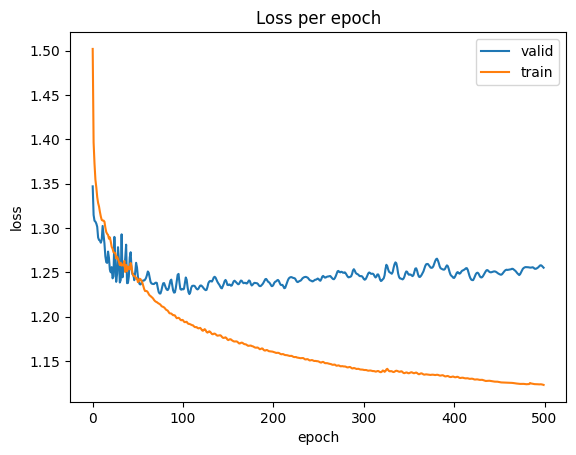

In [39]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

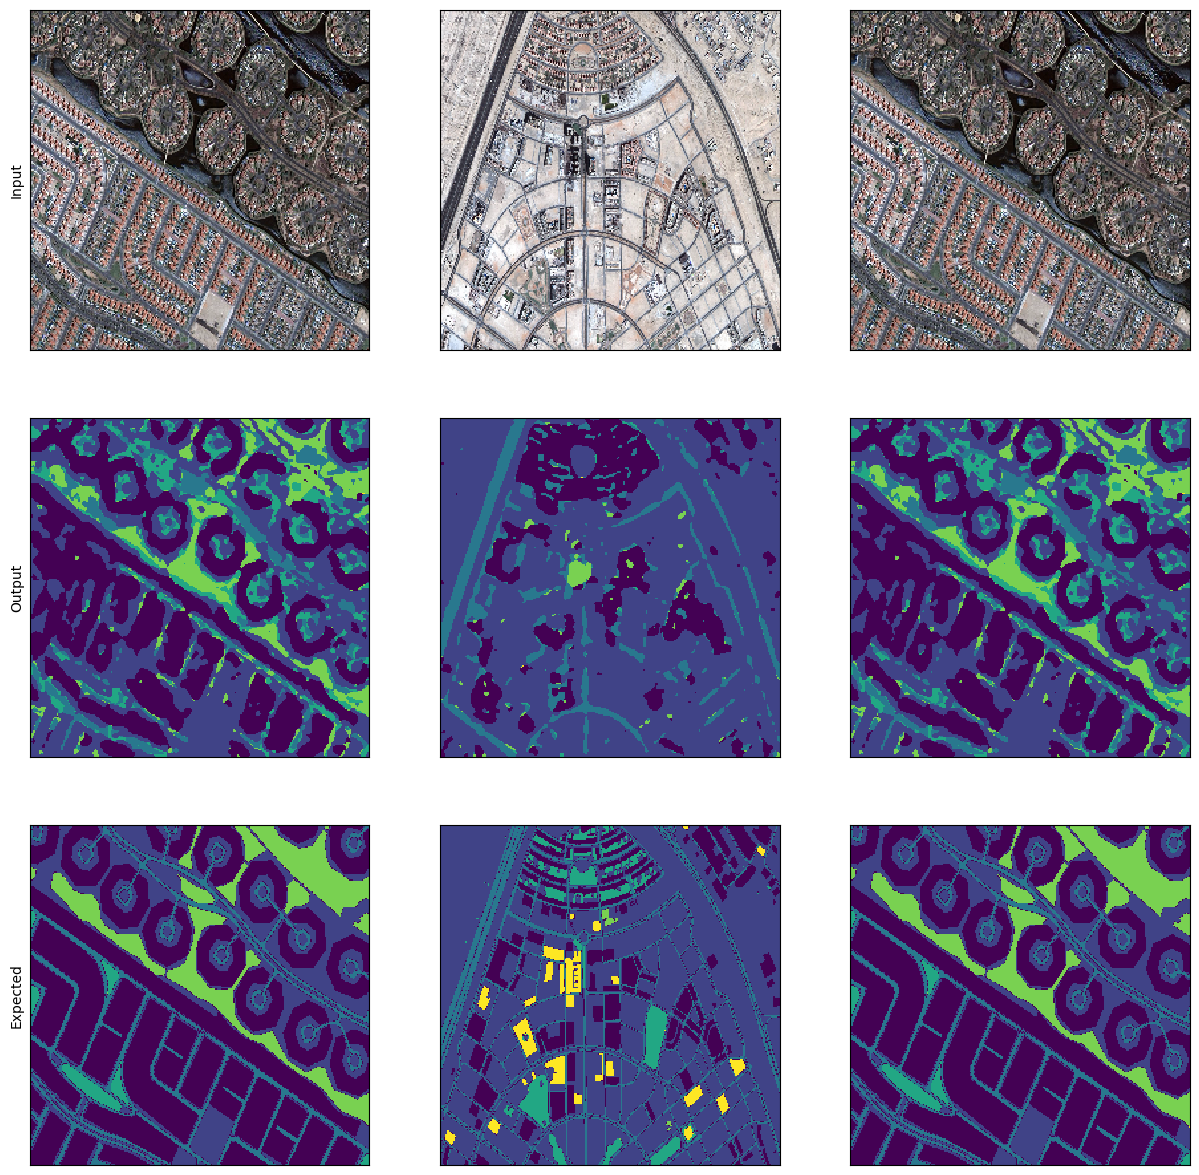

In [48]:
w = 3
fig, ax = plt.subplots(3, w, figsize=(15, 15))

ax[0][0].set_ylabel("Input")
ax[1][0].set_ylabel("Output")
ax[2][0].set_ylabel("Expected")
with torch.no_grad():
    for j in range(w):
        instances, targets = next(iter(test_loader))
        ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
        ax[0][j].set_xticks([])
        ax[0][j].set_yticks([])

        ax[1][j].imshow(torch.argmax(best_model(instances[0].to(device).unsqueeze(0)).squeeze(0).permute(1, 2, 0), dim=2).cpu().numpy().astype("uint8"), interpolation="None")
        ax[1][j].set_xticks([])
        ax[1][j].set_yticks([])

        ax[2][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
        ax[2][j].set_xticks([])
        ax[2][j].set_yticks([])

In [41]:
from utils.evaluation.multi_channel_iou import IoU
iou = IoU().to(device)

In [42]:
iou_test = torch.zeros([1, 7]).to(device)

for instances, targets in test_loader:
    predict = torch.zeros(targets.shape).to(device)
    res = torch.argmax(best_model(instances.to(device)), dim=-3)
    for ch in range(targets.shape[1]):
        predict[:, ch, :, :] = (res == ch)
    iou_test += iou(predict, targets.to(device))

iou_test /= len(test_loader)
iou_test

tensor([[2.8111e-01, 2.6926e-01, 5.6522e-01, 1.5806e-01, 1.1577e-01, 5.7812e-01,
         2.5492e-04]], device='cuda:0')

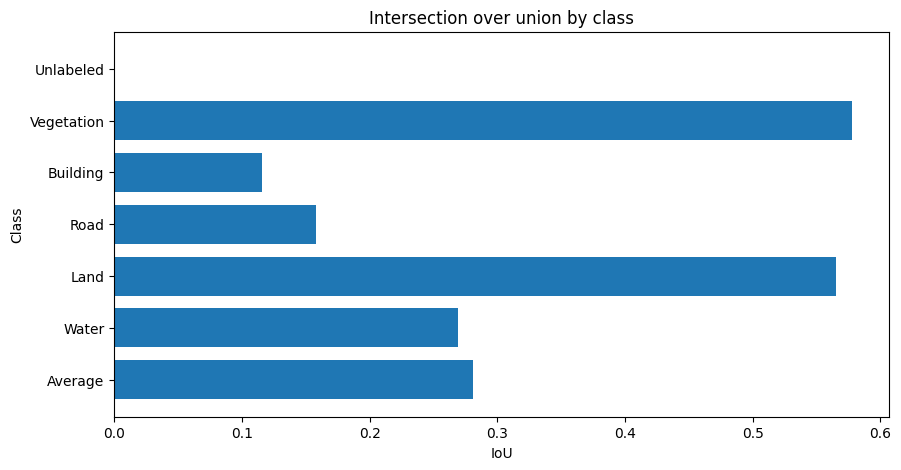

In [43]:
classes = ["Average", "Water", "Land", "Road", "Building", "Vegetation", "Unlabeled"]
values = list(iou_test.squeeze().cpu().numpy())

fig = plt.figure(figsize = (10, 5))

plt.barh(classes, values, height=0.75)
 
plt.xlabel("IoU")
plt.ylabel("Class")
plt.title("Intersection over union by class")
plt.show()

In [44]:
to_save = True

if to_save:
    torch.save(best_model.state_dict(), r"model\weights\best_bilinear_sun.zip")